# Introduction

Authors: Aaron Masih & Lauren Allen

Github: https://github.com/Aaronm1622/Trade-Outcome-Prediction

The primary objective of this project was to develop a predictive model that accurately forecasts the outcomes of congressional trades by determining whether each trade is profitable or unprofitable. Through analyzing historical trading data and incorporating various features the goal was to build a model that can assist in making informed trading decisions, potentially outperforming established benchmarks like the SPY (SPDR S&P 500 ETF Trust).

Key Goals:



*   Data Integration: Combine congressional trading data with relevant stock market data.
*   Feature Engineering: Develop meaningful features to enhance model performance.

*   Model Development: Train and evaluate multiple classifiers and combine them using ensemble methods.
*   Performance Evaluation: Compare models against baseline metrics and assess their ability to beat SPY.








# Datasets


Congressional Trading Dataset:


*   Columns: Ticker, Company, Trade Date, Transaction Type (Buy/Sell), Trade_Size_USD, Status, Name, Party, District, Chamber, etc.
Discuss what each column means and how many examples you have.
*   Source: Quiver Quantitative, a website used to track live congressional trades
*   Contains all known congressional trades from 2014 to 2024 with the aforementioned information.


High Growth Tech Stocks Dataset:

*   Columns: Date, Open, Close, High, Low, Volume.
*   Source: kaggle
*   Contains 8 companies and Spy with every recorded trade date and associated information from 2015 to 2021. The companies are Apple, Amazon, Facebook, Google, Microsoft, Netflix, Uber, Tesla, and Walmart.

















### **Features Overview**

- **Numerical Features:**
  - `Trade_Size_USD`: Monetary value of the trade.
  - `momentum_7d`: Momentum indicator over 7 days.
  
- **Categorical Features:**
  - `party_code`: Encoded political party.
  - `chamber_code`: Encoded chamber (House/Senate).
  - `state_code`: Encoded state.
  - `is_purchase`: Indicator if the transaction was a purchase.

- **Interaction Features:**
  - `trade_size_x_is_purchase`
  - `party_x_chamber`
  - `state_x_is_purchase`
  - `momentum_7d_x_trade_size`

- **Target Variable:**
  - `excess_return`: Binary indicator of whether the trade was profitable (1) or unprofitable (0).

- **Train-Test-Split:**
  - uses an 80/20 train test split for the models used in the project

### **Class Distribution**

| **Class**      | **Count** | **Percentage** |
|----------------|-----------|-----------------|
| Profitable (1) | 1,295     | 57.56%          |
| Unprofitable (0)| 953      | 42.44%          |
| **Total**      | 2,248     | 100%            |


The code calculates SPY’s return over the same period by referencing a precomputed spy_returns Series, which was created by taking the Close prices of SPY and computing either simple or log returns over the same window_days. If trade_date aligns with an index in spy_returns, it retrieves the corresponding value; if not, it uses the closest prior date’s return via .asof().

With both stock_return and spy_return computed, the code subtracts one from the other:


excess_return = stock_return - spy_return
This result, stored in the df['excess_return'] column, encodes how much better (or worse) the stock performed relative to the benchmark. The target variable is then binarized by checking if excess_return > 0.

Other Features from Trade Data:
In addition to the target, a variety of features are derived. For instance, party_code encodes the political party of the trader as a categorical code, and chamber_code similarly encodes the legislative chamber. The code in the FeatureEngineer.create_time_features method converts these categorical variables into numeric codes that models can interpret. The is_purchase feature, generated by examining the Transaction column, differentiates buy transactions from others.

Interaction Features:
The FeatureEngineer.create_interaction_features method in our code introduces terms like trade_size_x_is_purchase and momentum_7d_x_trade_size by multiplying existing features. For example, trade_size_x_is_purchase = df['trade_size'] * df['is_purchase'] reveals whether large purchases differ systematically from large sells. Similarly, momentum_7d_x_trade_size tries to capture the combined effect of market trends and transaction scale.

Features from Congressional Trade Data
The congressional dataset supplies key contextual attributes related to who made the trade, when it occurred, and what kind of transaction took place. Some features are derived directly, while others require encoding or processing.

Party Affiliation (party_code):
The trader’s party (e.g., Democrat, Republican) is a categorical variable. The code uses:


processed_df['party_code'] = pd.Categorical(processed_df['Party']).codes
This transforms party names into numeric codes, so the model can interpret the party dimension as an input variable. Although party alone may not guarantee predictive power, it can capture potential differences in information access or risk-taking behavior.

Legislative Chamber (chamber_code):
Similarly, the Chamber column, indicating whether the trader is in the House or the Senate, is encoded numerically:


processed_df['chamber_code'] = pd.Categorical(processed_df['Chamber']).codes
This numeric representation allows the model to consider if legislative position correlates with differences in trading outcomes.

State Code (state_code):
The State attribute is also encoded:


processed_df['state_code'] = pd.Categorical(processed_df['State']).codes
While state-level effects may be less obvious, this encoding allows for the possibility that certain regional economies or constituent industries affect the profitability of trades by members from those states.

Transaction Type (is_purchase):
Trades may be purchases or sales. To highlight this dimension, the code checks the Transaction column:


processed_df['is_purchase'] = processed_df['Transaction'].str.lower().str.contains('purchase').astype(int)
Purchases are marked as 1, others as 0. This binary indicator may capture strategic differences between acquiring a new position versus exiting one.

Trade Size (trade_size):
The Trade_Size_USD column often records ranges (e.g., $1,001 - $15,000). The code (FeatureEngineer._process_trade_size) transforms these ranges into numeric midpoints. For instance, $1,001 - $15,000 becomes approximately 8,000.5. If open-ended ranges appear, the code applies a logic to estimate a midpoint. These values are then median-imputed if missing and scaled.
The final trade_size feature thus quantifies the scale of the transaction as a meaningful numeric value, allowing the model to discern whether larger trades correlate with higher chances of outperformance.

Features from Stock Market Data
The historical stock data provides dynamic, market-oriented features that reflect the environment in which the trade was executed.

Momentum Indicator (momentum_7d):
The momentum_7d feature captures short-term trend information. Within FeatureEngineer.create_market_features, the code looks back a defined lookback_days (often 7) before the trade date:


momentum = (lookback_data['Close'].iloc[-1] / lookback_data['Close'].iloc[0] - 1)
This calculates the relative change in stock price over 7 days preceding the trade. A positive momentum indicates recent price gains, suggesting the trader may be capitalizing on an upward trend. A negative momentum suggests entering in a declining or uncertain market environment.

Market Conditions (Indirectly Captured):
Although not explicitly stated as a separate feature, the calculation of excess returns inherently considers overall market performance. By anchoring the target variable to SPY’s return, the modeling process already accounts for general market conditions. Additional features from the market data—such as volatility metrics or other timeframes—could be computed similarly if the code were extended.

Interaction Features
Interaction features are created to represent more complex relationships that may emerge only when two aspects are considered together. The FeatureEngineer.create_interaction_features method introduces:

trade_size_x_is_purchase:

df['trade_size_x_is_purchase'] = df['trade_size'] * df['is_purchase']
This feature reflects whether large trades differ if they are buys rather than sells. For example, a large purchase might signal confidence or insider-like timing, whereas large sales might convey caution or profit-taking strategies.

party_x_chamber:

df['party_x_chamber'] = df['party_code'] * df['chamber_code']
This interaction encodes whether certain party-chamber combinations correlate with distinct trading outcomes. Perhaps members of a particular party in the Senate behave differently than those in the House.

state_x_is_purchase:

df['state_x_is_purchase'] = df['state_code'] * df['is_purchase']
If certain states are associated with stronger industries or certain legislators have region-specific economic knowledge, combining state with transaction type could highlight patterns in how representatives of particular states time their buys vs. sells.

momentum_7d_x_trade_size:

df['momentum_7d_x_trade_size'] = df['momentum_7d'] * df['trade_size']
Even if large trades or positive momentum separately hint at profitability, their interaction might be more telling. For example, a substantial trade made during a rising market may be far more predictive of outperformance than a large trade made in stagnating conditions.

Scaling and Imputation
After generating and encoding these features, the code uses a StandardScaler to standardize numerical features, ensuring that attributes like trade_size and momentum_7d do not overshadow others due to differences in scale. Missing values, if encountered after these transformations, are handled through median imputation or other strategies, ensuring that the model only receives clean and meaningful data.


# Methodology
**Problem Framing**:
With a binary target variable indicating whether the excess return is positive, the problem becomes a straightforward classification task. Each trade is an instance, and the model must predict if the trade will yield a positive excess return over a set horizon.

**Model Selection**:
The code begins with a logistic regression baseline, as implemented in the ModelTrainer.train_baseline method. This baseline sets a reference point for complexity. Our other models such as train_random_forest and train_xgboost, apply grid searches to find optimal hyperparameters for each model, ensuring the chosen configuration generalizes well. Finally through what we learned in class about ensambling we used a train_voting_classifier that integrates all three models—logistic regression, random forest, and XGBoost—into a Voting Classifier that averages their predictions for potentially better stability and accuracy.

**Experimental Design & Model Validation**:
The dataset is split into training and testing sets. Cross-validation helps in tuning hyperparameters, with metrics like accuracy or ROC-AUC guiding the selection of best parameters. After training models are evaluated on the test set to confirm performance on unseen data.



# Modeling & Results
**Baseline Models**:
Logistic Regression sets the baseline for our experiment. It yields around 57.3% accuracy and from there any substantial improvements from more complex models suggest that non-linear or interaction effects are indeed present in the data.

**Hyperparameter Tuning**:
The code uses GridSearchCV to adjust parameters like the number of estimators or maximum depth for Random Forest, or learning rate and max depth for XGBoost. These searches ensure the final chosen parameters are those that generalize best, not just overfitting the training data.

**Comparison of Models**:
After tuning, the results look like this:


| Model               | Train Accuracy | Test Accuracy | ROC-AUC |
|---------------------|----------------|---------------|---------|
| Logistic Regression | 57.3%          | 57.3%         | 0.5497  |
| Random Forest       | 92.8%          | 63.6%         | 0.6701  |
| XGBoost             | 80.0%          | 63.6%         | 0.6502  |
| Voting Classifier    | 85.7%          | 64.9%         | 0.6686  |


The Voting Classifier shows a slight improvement over individual models, indicating that combining multiple perspectives can nudge performance upward, even if modestly.

Visualizations and Figures:
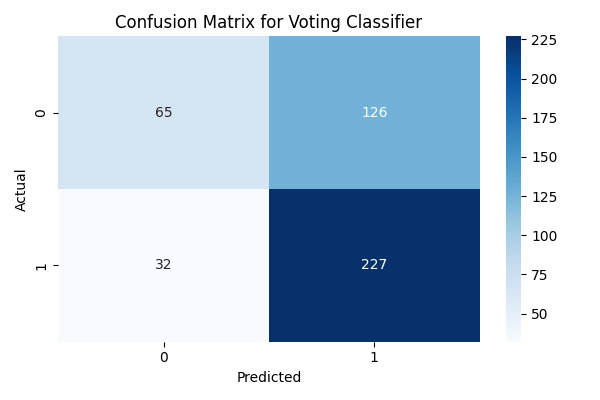



The confusion matrix plots actual classes along the vertical axis and predicted classes along the horizontal axis. For the Voting Classifier, the top-left cell shows the number of correctly identified unprofitable trades, while the bottom-right cell shows the number of correctly identified profitable trades. The top-right cell indicates unprofitable trades that were misclassified as profitable, and the bottom-left cell shows profitable trades missed by the classifier. Observing where the model errs—failing to catch certain profitable trades or mislabeling unprofitable ones—can guide subsequent refinement of features or threshold adjustments.

Top 10 Feature Importances for Random Forest:
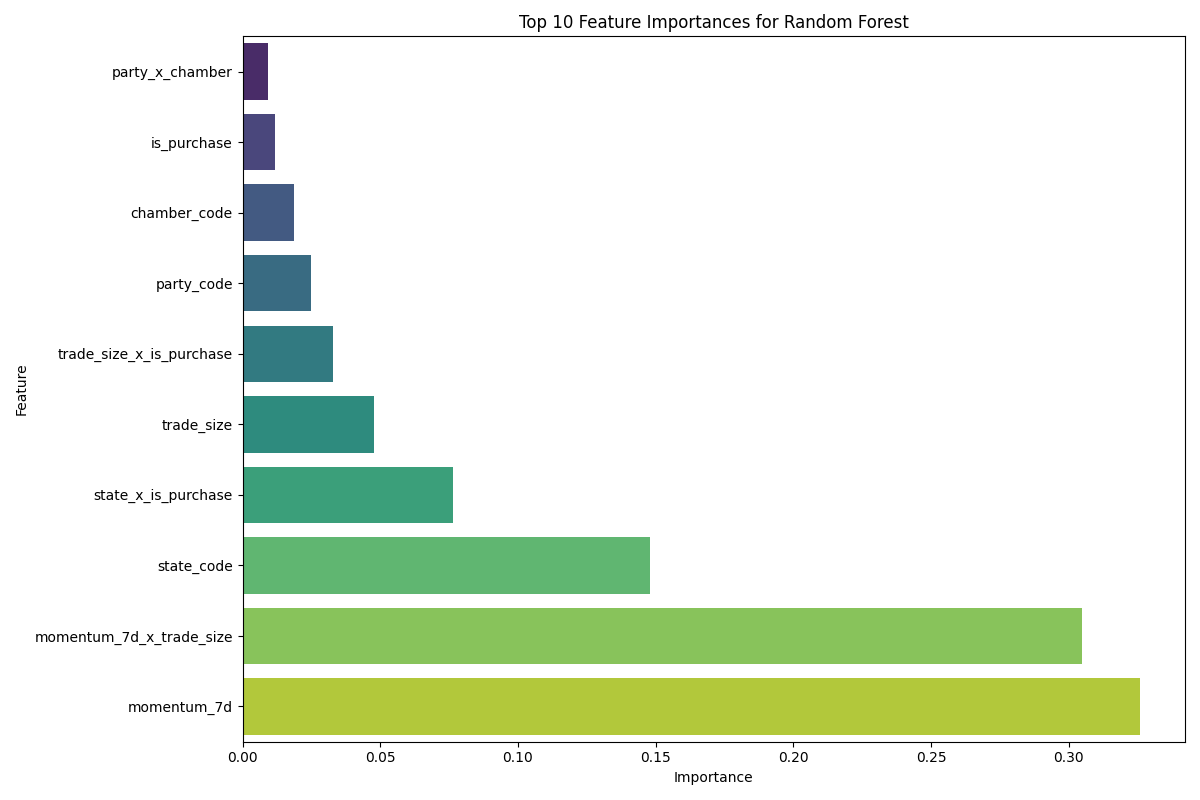

This bar chart ranks the 10 most influential features used by the Random Forest model. Features placed at the top, such as momentum_7d and momentum_7d_x_trade_size, have a stronger impact on the model’s decision-making. The code extracts these importance values from the model’s feature_importances_ attribute after training. High importance for momentum_7d suggests that recent market movements prior to the trade date heavily influence profitability predictions, while trade_size and its interactions also matter. Political or state-based features rank lower, implying that while they contribute, their predictive strength is more subtle than market-driven variables.

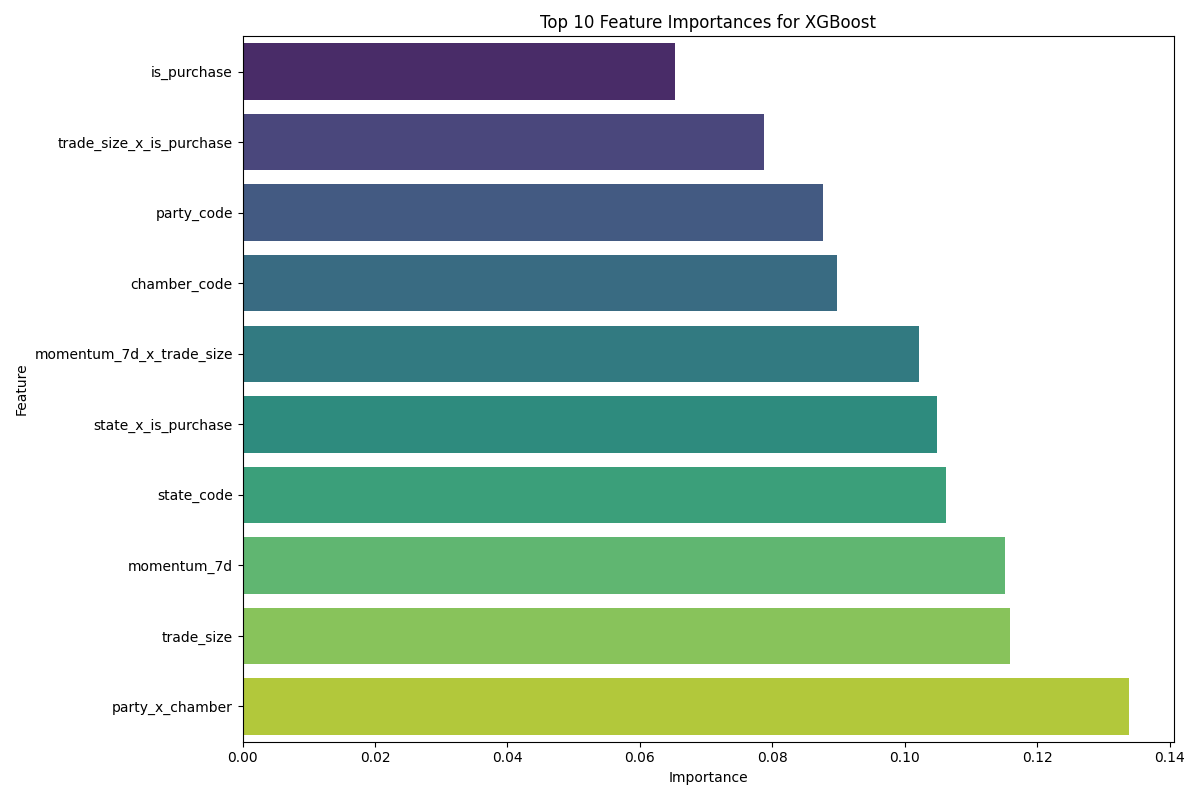

Explanation:
Similar to the Random Forest feature importance, this plot—obtained by accessing feature_importances_ from XGBoost—displays how strongly each feature informs the model’s splits. The presence of momentum_7d near the top again confirms its consistent value. Discrepancies or similarities in ranking compared to the Random Forest feature importances can validate whether certain patterns hold across different model structures.

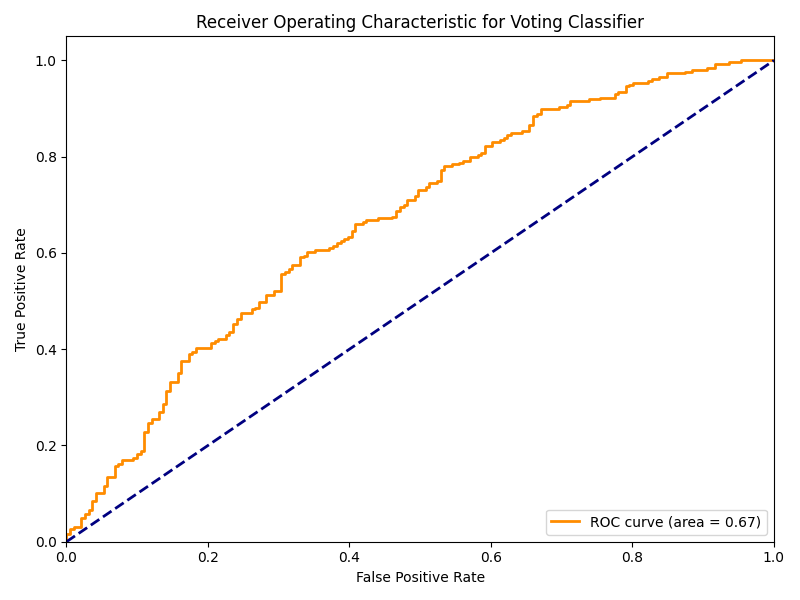

Explanation:
The Receiver Operating Characteristic (ROC) curve compares the true positive rate (sensitivity) to the false positive rate at various thresholds. The code computes this by invoking roc_curve on the predicted probabilities. The area under the ROC curve (AUC) around 0.67 indicates a moderate discriminative ability. The curve’s position above the diagonal (no-discrimination line) confirms that the model does better than random guessing. Adjusting these aforementioned thresholds could potentially improve the balance between correctly identified profitable trades and incorrectly labeled outcomes.

# Discussion
The our code and methods employed in this project reveal that congressional trade data that was integrated with historical stock prices does indeed contain some signals that enable modest predictions of outperformance. While no dramatic leaps in accuracy were observed we saw incremental improvements through ensemble methods like the Voting Classifier confirm that combining multiple modeling strategies can yield marginal gains.

The feature importances extracted from tree-based models highlight the preeminence of market-driven attributes such as short-term momentum indicators and trade magnitude. While political and categorical variables do appear in feature importance lists their influence is more subdued. This outcome implies that while political contexts might slightly shape trade outcomes, broader market conditions remain a more reliable predictor of relative success from our results.

The confusion matrix and ROC curve visualize the model’s performance profile,which illustrates where and how it succeeds or fails. By observing relatively balanced improvements and a test accuracy that barely surpasses simpler benchmarks suggests that the task remains challenging.

# Conclusion
Our project underscores the complexity and subtlety of predicting congressional trade profitability relative to a market benchmark. The incremental improvements we observed through ensemble techniques and the meticulous calculation of excess returns as seen in the DataLoader.calculate_excess_returns method—demonstrate that careful data alignment, log-return computations, and holistic evaluation strategies can uncover meaningful, if modest, predictive signals.

While surpassing SPY or achieving notably high accuracy remains elusive the project does provide valuable lessons. It confirms the importance of short-term market momentum, trade size, and certain interaction terms, and it exemplifies how rigorous and improtant proper preprocessing, feature engineering, and model selection routines can add incremental value. Given these insights, our future work might involve integrating more external data sources, refining feature engineering, and exploring more advanced modeling architectures to push these modest gains into more substantial and practically useful territory.

# Data Integration and Preprocessing

In [ ]:
import sys
import os

sys.path.append(os.path.abspath("./src"))
print(sys.path)

In [ ]:
from src.data.data_loader import DataLoader
print("DataLoader imported successfully!")

class Config:
    @staticmethod
    def load_config():
        return {
            'congress_excel_path': 'Data/Congressmen/congress-trading-all.xlsx',
            'stock_data_path': 'Data/archive',
            'spy_data_path': 'Data/archive/spy.csv'
        }
config = Config.load_config()
print(config)

data_loader = DataLoader(
    congress_excel_path=config['congress_excel_path'],
    stock_data_path=config['stock_data_path'],
    spy_data_path=config['spy_data_path']
)

# Load and preprocess congressional trading data
congress_data = data_loader.load_congress_data()
print(congress_data.head())

## Feature Engineering

In [ ]:

from src.features.feature_engineering import FeatureEngineer

feature_engineer = FeatureEngineer()

# Step 1: Generate Time Features
print("Creating time features...")
congress_data = feature_engineer.create_time_features(congress_data)

# Step 2: Create Market Features
print("Creating market features...")
stock_data = data_loader.load_stock_data()

# Generate market features
market_features = feature_engineer.create_market_features(congress_data, stock_data)

# Add a suffix to prevent column conflicts
market_features = market_features.add_suffix('_market')

# Step 3: Combine Features
print("Combining features...")
congress_data = congress_data.join(market_features)

# Step 4: Create Interaction Features
print("Creating interaction features...")
congress_data = feature_engineer.create_interaction_features(congress_data)

# Step 5: Display Final Columns
print("Feature Engineering Complete. Final Columns:")
print(congress_data.columns)

# Preview the first few rows
print(congress_data.head())

## Model Training and Evaluation

In [ ]:
from src.models.model_trainer import ModelTrainer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
from src.visualization.visualizer import Visualizer
import matplotlib.pyplot as plt

model_trainer = ModelTrainer()
visualizer = Visualizer()

# Step 1: Prepare data
print("Preparing data for modeling...")
X, y = model_trainer.prepare_data(congress_data)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Train individual models
print("Training individual models...")
baseline_model = model_trainer.train_baseline(X_train, y_train)
rf_model = model_trainer.train_random_forest(X_train, y_train)
xgb_model = model_trainer.train_xgboost(X_train, y_train)

# Step 3: Train Voting Ensemble
print("Training Voting Classifier Ensemble...")
voting_model = model_trainer.train_voting_classifier(X_train, y_train)

# Step 4: Evaluate models on the test set
models = model_trainer.models  # Includes the voting ensemble
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    fig_cm = visualizer.plot_confusion_matrix(cm, model_name)
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    fig_roc = visualizer.plot_roc_curve(fpr, tpr, roc_auc, model_name)
    plt.show()

# Step 5: Output Voting Ensemble Summary
print("\nVoting Classifier Ensemble Summary:")
print(f"Voting Classifier Test Accuracy: {accuracy_score(y_test, voting_model.predict(X_test)):.4f}")
print(f"Voting Classifier ROC-AUC: {roc_auc_score(y_test, voting_model.predict_proba(X_test)[:, 1]):.4f}")